# Model Prediction Analysis

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.metrics import cohen_kappa_score


# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [5]:
# Loading seizure level metadata
sz_annots = pd.read_pickle(ospj(prodatapath,'optimized_predicted_channels.pkl'))
sz_annots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
0,HUP224,HUP224_phaseII,NRG,1.0,71156.5900,71190.99,0.75,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[0.0, 1.0, 0.0, 1.0, 23.0, 0.0, 0.0, 0.0, 0.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
1,HUP224,HUP224_phaseII,NRG,0.0,202170.6800,202243.03,0.75,"[LB02, LB03, LF03, LX08, LX10, LZ02, LZ03, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX08, LX09, LX1...","[LB03, LF03, LQ02, LX08, LX10, LZ02, LZ03, LZ0...","[LB03, LB04, LF03, LF04, LQ02, LQ03, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[12.5, 16.5, 17.5, 16.0, 20.0, 45.0, 35.0, 16....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
2,HUP224,HUP224_phaseII,NRG,0.0,227267.9600,227350.65,0.75,"[LB02, LB03, LF03, LX07, LX08, LX10, LZ02, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX07, LX08, LX0...","[LB01, LB02, LB03, LF03, LX08, LX10, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LF03, LF04, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA07, LA09, LB0...","[9.5, 11.0, 10.5, 11.0, 20.5, 36.0, 14.0, 4.5,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339234.20,0.75,"[LB02, LB03, LF03, LZ02, LZ04, RB01, RB03, RC0...","[LB02, LB03, LB04, LF03, LF04, LZ02, LZ03, LZ0...","[LB01, LB02, LB03, LB04, LB05, LC01, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LB05, LB06, LC01, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[7.0, 8.0, 7.0, 8.0, 5.0, 0.0, 0.0, 6.0, 6.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
4,HUP224,HUP224_phaseII,NRG,0.0,415751.7187,415805.57,0.75,"[LB02, LB03, LF03, LX10, LZ02, LZ04, RB01, RB0...","[LB02, LB03, LB04, LF03, LF04, LX10, LX11, LZ0...","[LB01, LB02, LB03, LC01, LC02, LF03, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LF0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[7.5, 9.5, 8.5, 11.0, 14.5, 3.0, 0.0, 0.0, 6.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."


## Annotator Replication

### Seizure -- channel

TtestResult(statistic=-25.3968348804712, pvalue=2.557565336577242e-138, df=10982.0)
-1.389312379457519


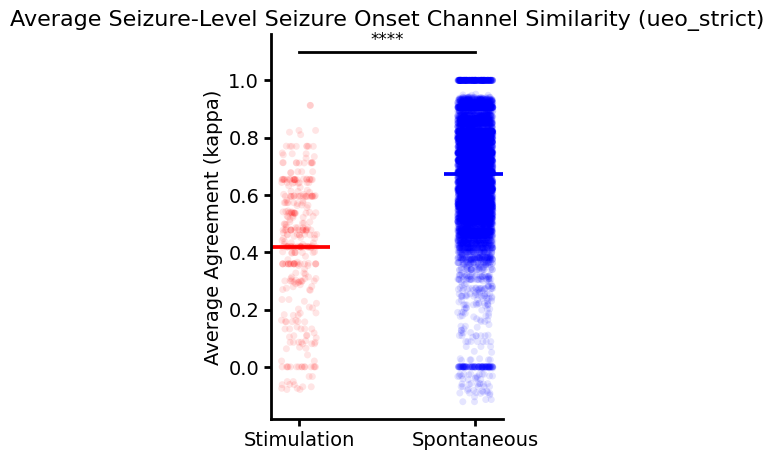

In [6]:
# Can also toggle median or mean within patients
all_stim_annots = []
all_spont_annots = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
for pt,group in sz_annots.groupby("Patient"):
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]

    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        chs = group.loc[i,f'{annot_type}_chs_{con_type}']
        ch_mask = np.array([l in chs for l in group.loc[i,'all_channels']])
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_chs_{con_type}']
            ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_channels']])
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
    # plt.figure()
    # cols=['red','blue']
    # for i,dist in enumerate([stim_kappas,spont_kappas]):
    #     sns.stripplot(x=np.ones(len(dist))*i,y=dist,color=cols[i])
    # plt.title(pt)
    # plt.ylim([-.5,1.5])
    # plt.xlim([-.5,1.5])
    # plt.ylabel('Cohen\'s kappa (agreement)')
    # plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
    avg_stim_annots.append(np.nanpercentile(stim_kappas,75))
    avg_spont_annots.append(np.nanpercentile(spont_kappas,75))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)

all_stim_annots = [item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])]
all_spont_annots = [item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])]

all_stim_annots = np.array(all_stim_annots)
all_stim_annots = all_stim_annots[~np.isnan(all_stim_annots)]
all_spont_annots = np.array(all_spont_annots)
all_spont_annots = all_spont_annots[~np.isnan(all_spont_annots)]
plt.figure(figsize=(3,5))
all_xs = np.concatenate((np.zeros((len(all_stim_annots),))+.2,np.ones((len(all_spont_annots),))-.2),axis=0)
all_ys = np.concatenate((all_stim_annots,all_spont_annots))
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",palette=["red","blue"],
              estimator='mean')
plt.setp(ax.collections, sizes=[2000])
sns.stripplot(x=all_xs,y=all_ys,palette = ['red','blue'],alpha=.1,dodge=False)

sns.despine()
plt.xticks([0,1],["Stimulation","Spontaneous"])
plt.ylabel("Average Agreement (kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Channel Similarity ({annot_type}_{con_type})")
print(sc.stats.ttest_ind(all_stim_annots,all_spont_annots))
print(cohens_d(all_stim_annots,all_spont_annots))
ax.plot([0, 1], [1.1, 1.1], color='black', linewidth=2)
asterisk_y = 1.11  # slightly above the bar
asterisk_x_center = 0.5  # center of the x-axis range

# Plot the four asterisks as a single text element
ax.text(asterisk_x_center, asterisk_y, '****', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.savefig(ospj(figpath,'sz_channel_ueo_similarity.pdf'),bbox_inches='tight')

In [7]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
example_pt = 'HUP250'
group = sz_annots[sz_annots.Patient == 'HUP250']
group.sort_values(ascending=False,by='stim',inplace=True)
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)
for i in range(len(group)):
    chs = group.loc[i,f'{annot_type}_chs_{con_type}']
    if group.loc[i,'stim'] == 1:
        print(f"{i} is stim")
    ch_mask = np.array([l in chs for l in group.loc[i,'all_channels']])
    for j in range(i+1,len(group)):
        chs2 = group.loc[j,f'{annot_type}_chs_{con_type}']
        ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_channels']])        
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

0 is stim


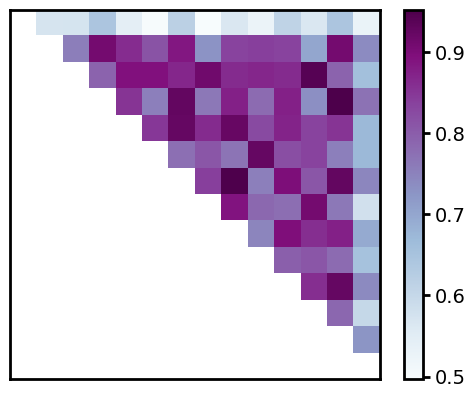

In [8]:
plt.imshow(kappa_mat,cmap = 'BuPu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,f'ueo_heatmap_pt-{example_pt}.pdf'),bbox_inches='tight')

### Seizure -- region

In [9]:
pt_groups = sz_annots.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict']:
            chs = row[col]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)

In [10]:
all_stim_annots = []
all_spont_annots = []
all_stim_patients = []
all_spont_patients = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
for pt,group in sz_annots.groupby("Patient"):
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        all_rs = group.loc[i,'all_rs']
        chs = group.loc[i,f'{annot_type}_rs_{con_type}']
        ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
            ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))

    avg_stim_annots.append(np.nanpercentile(stim_kappas,75))
    avg_spont_annots.append(np.nanpercentile(spont_kappas,75))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)
    all_stim_patients.append([pt]*len(stim_kappas))
    all_spont_patients.append([pt]*len(spont_kappas))
    

flat_stim_annots = np.array([item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_annots = np.array([item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_stim_patients = np.array([item for sublist in all_stim_patients for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_patients = np.array([item for sublist in all_spont_patients for item in (sublist if isinstance(sublist, list) else [sublist])])

flat_stim_patients = flat_stim_patients[~np.isnan(flat_stim_annots)]
flat_stim_annots = flat_stim_annots[~np.isnan(flat_stim_annots)]
flat_spont_patients = flat_spont_patients[~np.isnan(flat_spont_annots)]
flat_spont_annots = flat_spont_annots[~np.isnan(flat_spont_annots)]


TtestResult(statistic=-23.70355336806352, pvalue=3.5563162932454002e-121, df=10977.0)
-1.2966924208642019


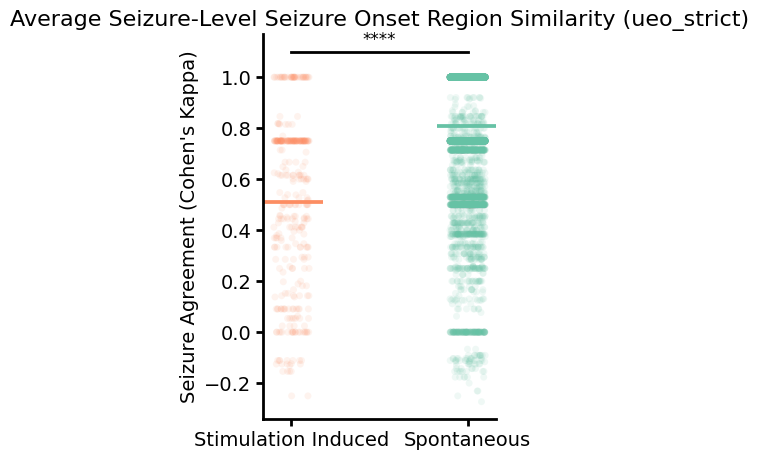

In [11]:
plt.figure(figsize=(3,5))
all_xs = np.concatenate((np.zeros((len(flat_stim_annots),)),np.ones((len(flat_spont_annots),))),axis=0)
all_ys = np.concatenate((flat_stim_annots,flat_spont_annots))
all_hues = np.concatenate((flat_stim_patients,flat_spont_patients))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='mean',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[2000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.1,
            #   hue=all_hues,
              palette = pal[:2][::-1])
#
sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.ttest_ind(flat_stim_annots,flat_spont_annots))
print(cohens_d(flat_stim_annots,flat_spont_annots))
ax.plot([0, 1], [1.1, 1.1], color='black', linewidth=2)
asterisk_y = 1.11  # slightly above the bar
asterisk_x_center = 0.5  # center of the x-axis range

# Plot the four asterisks as a single text element
ax.text(asterisk_x_center, asterisk_y, '****', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.savefig(ospj(figpath,'sz_region_ueo_similarity.pdf'),bbox_inches='tight')

### Patient -- region

MannwhitneyuResult(statistic=55.5, pvalue=0.006825350634956817)
-1.1282946342361744


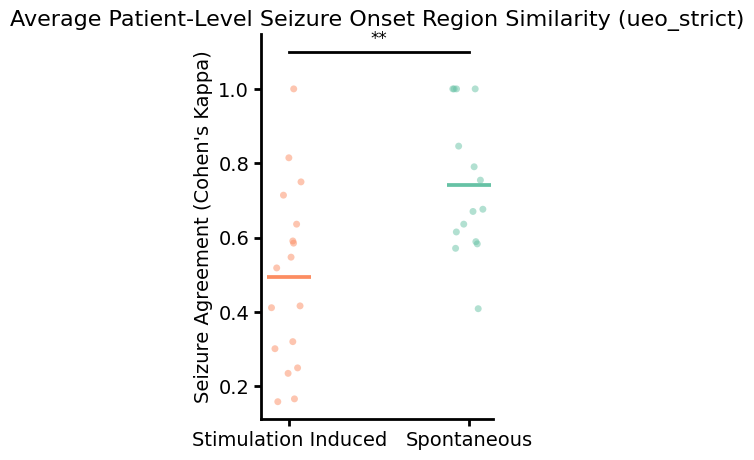

In [12]:
avg_stim_annots = np.array(avg_stim_annots)
avg_stim_annots = avg_stim_annots[~np.isnan(avg_stim_annots)]
avg_spont_annots = np.array(avg_spont_annots)
avg_spont_annots = avg_spont_annots[~np.isnan(avg_spont_annots)]
plt.figure(figsize=(3,5))
all_xs = np.concatenate((np.zeros((len(avg_stim_annots),)),np.ones((len(avg_spont_annots),))),axis=0)
all_ys = np.concatenate((avg_stim_annots,avg_spont_annots))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='mean',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.5,palette = pal[:2][::-1])

ax.plot([0, 1], [1.1, 1.1], color='black', linewidth=2)
asterisk_y = 1.11  # slightly above the bar
asterisk_x_center = 0.5  # center of the x-axis range
ax.text(asterisk_x_center, asterisk_y, '**', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Patient-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(avg_stim_annots,avg_spont_annots))
print(cohens_d(avg_stim_annots,avg_spont_annots))

## Seizure spread timing

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

In [13]:
pt_groups = sz_annots.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict']:
            chs = row[col]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
sz_annots.dropna(axis=0,subset='ueo_rs_strict',inplace=True)
sz_annots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)

In [14]:
sz_annots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,ueo_rs_strict,all_rs
0,HUP224,HUP224_phaseII,NRG,1.0,71156.5900,71190.99,0.75,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[0.0, 1.0, 0.0, 1.0, 23.0, 0.0, 0.0, 0.0, 0.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left amygdala , left hippocampus , left in...","[EmptyLabel, left amygdala , left middle tem..."
1,HUP224,HUP224_phaseII,NRG,0.0,202170.6800,202243.03,0.75,"[LB02, LB03, LF03, LX08, LX10, LZ02, LZ03, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX08, LX09, LX1...","[LB03, LF03, LQ02, LX08, LX10, LZ02, LZ03, LZ0...","[LB03, LB04, LF03, LF04, LQ02, LQ03, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[12.5, 16.5, 17.5, 16.0, 20.0, 45.0, 35.0, 16....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem..."
2,HUP224,HUP224_phaseII,NRG,0.0,227267.9600,227350.65,0.75,"[LB02, LB03, LF03, LX07, LX08, LX10, LZ02, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX07, LX08, LX0...","[LB01, LB02, LB03, LF03, LX08, LX10, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LF03, LF04, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA07, LA09, LB0...","[9.5, 11.0, 10.5, 11.0, 20.5, 36.0, 14.0, 4.5,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem..."
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339234.20,0.75,"[LB02, LB03, LF03, LZ02, LZ04, RB01, RB03, RC0...","[LB02, LB03, LB04, LF03, LF04, LZ02, LZ03, LZ0...","[LB01, LB02, LB03, LB04, LB05, LC01, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LB05, LB06, LC01, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[7.0, 8.0, 7.0, 8.0, 5.0, 0.0, 0.0, 6.0, 6.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem..."
4,HUP224,HUP224_phaseII,NRG,0.0,415751.7187,415805.57,0.75,"[LB02, LB03, LF03, LX10, LZ02, LZ04, RB01, RB0...","[LB02, LB03, LB04, LF03, LF04, LX10, LX11, LZ0...","[LB01, LB02, LB03, LC01, LC02, LF03, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LF0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[7.5, 9.5, 8.5, 11.0, 14.5, 3.0, 0.0, 0.0, 6.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem..."


In [15]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
        
sz_annots[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots.groupby("Patient"):
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    electrode_regions = pd.read_pickle(region_path)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [16]:
time_points =  np.arange(0,60.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [17]:
sz_annots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,ueo_rs_strict,all_rs,sz_locs,sz_loc_times
0,HUP224,HUP224_phaseII,NRG,1.0,71156.5900,71190.99,0.75,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[0.0, 1.0, 0.0, 1.0, 23.0, 0.0, 0.0, 0.0, 0.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left amygdala , left hippocampus , left in...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left fusiform , left hippo...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 16.0, 0.0..."
1,HUP224,HUP224_phaseII,NRG,0.0,202170.6800,202243.03,0.75,"[LB02, LB03, LF03, LX08, LX10, LZ02, LZ03, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX08, LX09, LX1...","[LB03, LF03, LQ02, LX08, LX10, LZ02, LZ03, LZ0...","[LB03, LB04, LF03, LF04, LQ02, LQ03, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[12.5, 16.5, 17.5, 16.0, 20.0, 45.0, 35.0, 16....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left fusiform , left hippo...","[16.5, 10.0, 0.0, 0.0, 0.0, 5.0, 27.0, 16.5, 1..."
2,HUP224,HUP224_phaseII,NRG,0.0,227267.9600,227350.65,0.75,"[LB02, LB03, LF03, LX07, LX08, LX10, LZ02, LZ0...","[LB02, LB03, LB04, LF03, LF04, LX07, LX08, LX0...","[LB01, LB02, LB03, LF03, LX08, LX10, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LF03, LF04, LX08, LX0...","[LA01, LA02, LA03, LA04, LA05, LA07, LA09, LB0...","[9.5, 11.0, 10.5, 11.0, 20.5, 36.0, 14.0, 4.5,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left fusiform , left hippo...","[11.0, 12.0, 0.0, 0.0, 0.0, 6.5, 23.0, 14.0, 1..."
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339234.20,0.75,"[LB02, LB03, LF03, LZ02, LZ04, RB01, RB03, RC0...","[LB02, LB03, LB04, LF03, LF04, LZ02, LZ03, LZ0...","[LB01, LB02, LB03, LB04, LB05, LC01, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LB05, LB06, LC01, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[7.0, 8.0, 7.0, 8.0, 5.0, 0.0, 0.0, 6.0, 6.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left fusiform , left hippo...","[8.0, 11.0, 0.0, 0.0, 0.0, 7.5, 17.5, 120.5, 1..."
4,HUP224,HUP224_phaseII,NRG,0.0,415751.7187,415805.57,0.75,"[LB02, LB03, LF03, LX10, LZ02, LZ04, RB01, RB0...","[LB02, LB03, LB04, LF03, LF04, LX10, LX11, LZ0...","[LB01, LB02, LB03, LC01, LC02, LF03, LZ02, LZ0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LF0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[7.5, 9.5, 8.5, 11.0, 14.5, 3.0, 0.0, 0.0, 6.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left hippocampus , left inferior temporal ,...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left fusiform , left hippo...","[9.5, 12.0, 0.0, 0.0, 0.0, 9.5, 17.0, 14.5, 12..."


In [18]:
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots.groupby("Patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if np.sum(loc_idx) > 0:
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))
stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL

stim_spread_df['Patient'] = all_pts
stim_spread_df_long = stim_spread_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')


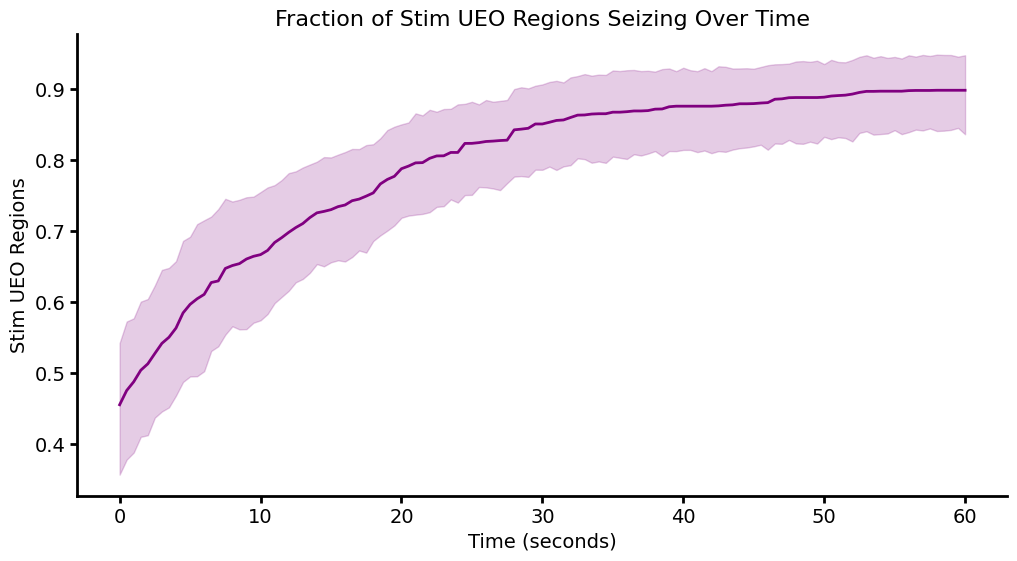

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='purple')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim UEO Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim UEO Regions')
sns.despine()
# plt.ylim((0,1))

### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [20]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots.groupby("Patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_rs = np.array([r for r in st_sz.all_rs if r != 'EmptyLabel'])
                null_locs = sample_rs[np.random.randint(0,len(sample_rs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_locs
                times = sp_sz.sz_loc_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if np.sum(loc_idx) > 0:
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['Patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')

In [21]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

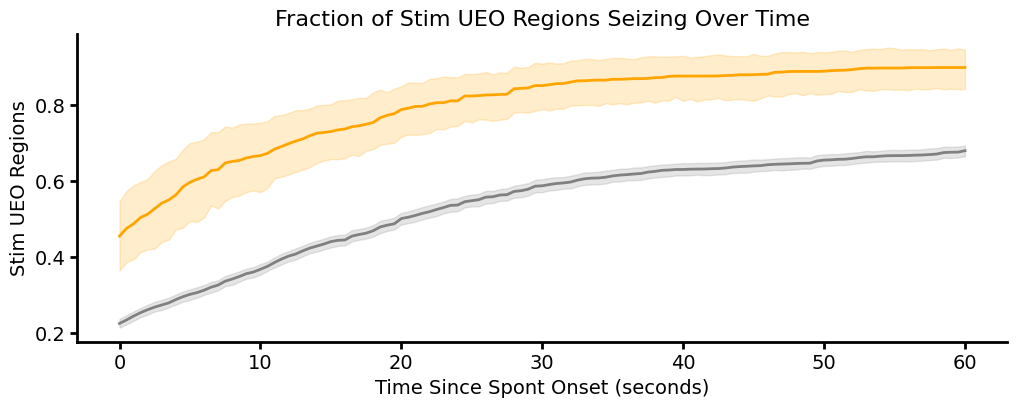

In [22]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim UEO Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Stim UEO Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
plt.savefig(ospj(figpath,'stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

### Calculating recruitment speed

In [23]:
null_speed_df = null_spread_df.iloc[:,:-1].diff(axis=1)
null_speed_df['Patient'] = null_spread_df.Patient
null_speed_df_long = null_speed_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')

stim_speed_df = stim_spread_df.iloc[:,:-1].diff(axis=1)
stim_speed_df['Patient'] =stim_spread_df.Patient
stim_speed_df_long = stim_speed_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')

In [24]:
is_sig = np.zeros((int(20/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,20.5,0.5)):
    stim_dist = stim_speed_df_long[stim_speed_df_long.Time == t]['Fraction']
    null_dist = null_speed_df_long[null_speed_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

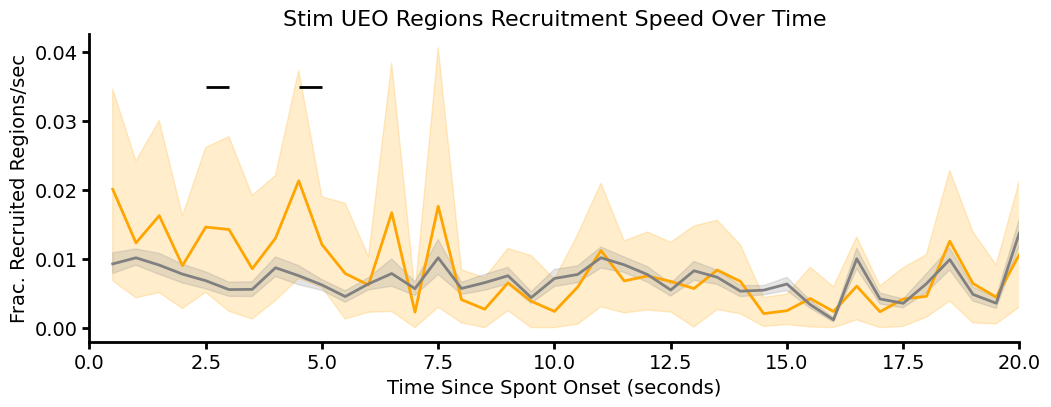

In [25]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_speed_df_long, x='Time', y='Fraction',color='orange',ax=ax)
sns.lineplot(data=null_speed_df_long, x='Time', y='Fraction',color='grey',ax=ax)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Stim UEO Regions Recruitment Speed Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Frac. Recruited Regions/sec')
sns.despine(ax=ax)
plt.xlim((0,20))

# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(0.035, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(0.035, time_points[i], time_points[i], color='k', linewidth=2)

# plt.savefig(ospj(figpath,'stim_ueo_region_recruitment_speed.pdf'),bbox_inches='tight')

### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [63]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots.groupby("Patient"):
    spont_szs = group[group.stim == 0]
    print(pt)
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_rs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if np.sum(loc_idx) > 0:
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
spont_spread_df['Patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')

HUP224
HUP225
HUP229
HUP230
HUP235
HUP238
HUP246
HUP247
HUP249
HUP250
HUP253
HUP257
HUP261
HUP263
HUP266
HUP267
HUP273


In [64]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

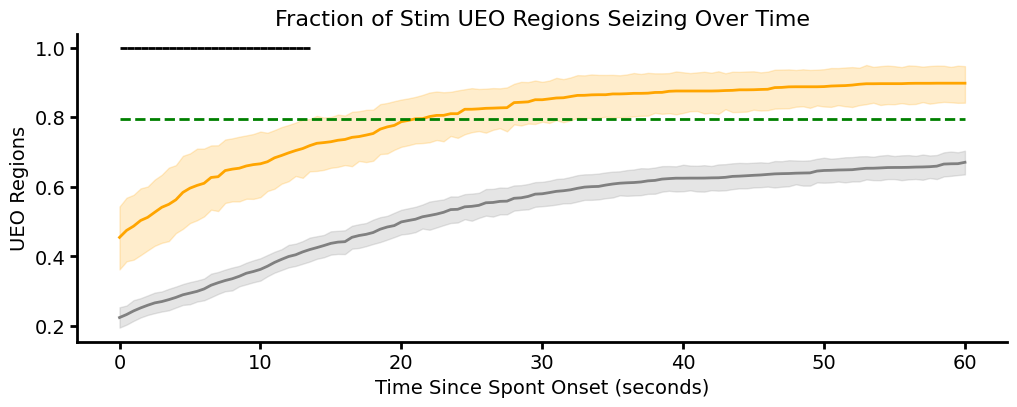

In [66]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2)
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.boxplot(plotting_df[plotting_df.Time == 0], x='Time',y='Fraction',color='green')#,linewidth=2,err_style='bars')
# plt.boxplot(x=plotting_df.Fraction,positions=[-2],showmeans=True)
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim UEO Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('UEO Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

## Predicting Stim Seizure Similarity

### Seizure duration

Make a dataframe with the following columns: Patient, stim seizure, spontaneous seizure, stim onset regions, spontaneous onset regions, kappa, stim seizure duration, hippocampal localization? 

273 is atypical

In [68]:
model_dict = {key:[] for key in ['patient','onset','agreement','stim_sz_length',]}
annot_type = 'ueo'
con_type = 'strict'

for pt,group in sz_annots.groupby('Patient'):
    group.sort_values(ascending=False,by='stim',inplace=True)
    group.reset_index(drop=True,inplace=True)
    for i in range(len(group)):
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                all_rs = group.loc[i,'all_rs']
                chs = group.loc[i,f'{annot_type}_rs_{con_type}']
                ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
                chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
                ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
                model_dict['patient'].append(pt)
                model_dict['onset'].append(group.loc[i,'approximate_onset'])
                model_dict['agreement'].append(cohen_kappa_score(ch_mask,ch_mask2))
                model_dict['stim_sz_length'].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
model_df = pd.DataFrame(model_dict)

In [69]:
# Join the two tables and make linear model!
lm_df = pd.merge(model_df,patient_table[['ptID','typical','mtle']],left_on='patient',right_on='ptID',how='left').drop('ptID',axis=1)

In [70]:
lm_df_grouped = lm_df.groupby('onset')
lm_df_left = lm_df_grouped[[l for l in lm_df.columns if l != 'agreement']].max()
lm_df_left['agreement'] = lm_df_grouped['agreement'].apply(lambda x: np.nanpercentile(x,75))
lm_df_left.reset_index(drop=True,inplace=True)

In [71]:
lm_df_left

,patient,onset,stim_sz_length,typical,mtle,agreement
0,HUP229,1109.40000,67.51000,1.0,1.0,0.166667
1,HUP230,3860.24000,18.16000,1.0,1.0,0.714286
2,HUP257,8576.79000,67.34000,1.0,1.0,0.636364
3,HUP238,10652.96973,139.37027,1.0,1.0,0.814815
4,HUP266,12508.67000,44.67000,0.0,0.0,0.564480
5,HUP266,13618.01000,37.94000,0.0,0.0,0.081695
6,HUP246,14638.42000,84.85000,1.0,1.0,0.235294
7,HUP266,14777.76000,39.17000,0.0,0.0,0.564480
8,HUP247,15093.12000,24.40000,1.0,0.0,0.750000
9,HUP253,15516.73000,36.68000,0.0,1.0,1.000000


In [72]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

# Load data
dat = lm_df_left

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('agreement ~ stim_sz_length + typical + mtle', data=dat).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              agreement   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.122
Method:                 Least Squares   F-statistic:                    0.3107
Date:                Mon, 10 Jun 2024   Prob (F-statistic):              0.817
Time:                        16:04:08   Log-Likelihood:              -0.022628
No. Observations:                  20   AIC:                             8.045
Df Residuals:                      16   BIC:                             12.03
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4235      0.134      3.